# Настройка модели и подготовка данных


---



In [ ]:
!pip install --quiet -U mistralai datasets seaborn scikit-learn faiss-cpu umap-learn umap-learn[plot] scipy polars dask[dataframe] gdown

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

## Базовая конфигурация


---

### Инициализация модели

In [ ]:
import json

with open('/content/drive/MyDrive/hw2/config.json', 'r') as file:
    api_keys = json.load(file)

In [ ]:
from mistralai import Mistral

def run_mistral(user_message, api_key, model="mistral-large-latest"):
    client = Mistral(api_key=api_key)
    messages = [
        {"role": "user", "content": user_message}
    ]
    chat_response = client.chat.complete(
        model=model,
        messages=messages,
        stop=["."]
    )
    return chat_response.choices[0].message.content

### Обработка предложений из датасета и формирование шаблона промпта


In [ ]:
import random

# формирует запрос, где два варианта предложения идут в случайном порядке
def user_message(inquiry, instruction):
    sentence_bad = inquiry['sentence_bad']
    sentence_good = inquiry['sentence_good']
    sentences = [(1, sentence_bad), (2, sentence_good)]
    random.shuffle(sentences)
    user_message = (
        f"""
        {instruction}
        <<<
        1. {sentences[0][1]}
        2. {sentences[1][1]}
        >>>
        """
    )
    return user_message, sentences

In [ ]:
def get_correct_answer(sentences, sentence_good):
    correct_answer = 1 if sentences[0][1] == sentence_good else 2
    return correct_answer

In [ ]:
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names
from tqdm import tqdm
import polars as pl

# использую polars, потому что pandas все-таки медленный для датасетов такого размера (и ресурсозатратный) (дальше просто будет еще х2)
# (после курсовой поняла, что надо все-таки освоить)

# configs = get_dataset_config_names("nyu-mll/blimp")
# datasets = []
# for config in tqdm(configs, desc="Loading"):
#     ds = load_dataset("nyu-mll/blimp", config)
#     shuffled_ds = ds["train"].shuffle(seed=42)
#     datasets.append(shuffled_ds.select(range(10)))

# combined_dataset = concatenate_datasets(datasets)
# query_dataset = combined_dataset.shuffle(seed=42)
# query_dataset = pl.DataFrame(query_dataset.to_dict())
# query_dataset.write_parquet('/content/drive/My Drive/hw2/query_dataset.parquet')
query_dataset = pl.read_parquet('/content/drive/My Drive/hw2/query_dataset.parquet')
configs = query_dataset['UID'].unique().to_list()
len(configs)

In [ ]:
len(query_dataset)

In [ ]:
def format_prompt(index, sentences, correct_i):
    return (
        f"Example {index+1}:\n"
        f"1: {sentences[0]}\n"
        f"2: {sentences[1]}\n"
        f"Correct sentence: {correct_i}"
)

In [ ]:
def prepare_sentences(good_sent, bad_sent, used_correct=[]):
# предотвращает случаи, где во всех парах примеров
# грамматичные и неграмматичные предложения идут в одном порядке
    sentences = [good_sent, bad_sent]
    # если несколько подряд правильный ответ был 1,
    # то ставим правильное предложение вторым
    if used_correct and all(x == 1 for x in used_correct[-3:]):
        sentences = [bad_sent, good_sent]
    # если наоборот все время был ответ 2, то первым
    elif used_correct and all(x == 2 for x in used_correct[-3:]):
        sentences = [good_sent, bad_sent]
    # иначе рандомно мешаем
    else:
        random.shuffle(sentences)
    correct_i = sentences.index(good_sent) + 1
    return sentences, correct_i

In [ ]:
def generate_mapped_prompts(dataset, shot=3, use_polars=False):
# генерирует промпты из датасета, группируя по N обучающих примеров
# на каждый тестовый (дефолтный случай)
    mapped_prompts = []
    for i in tqdm(range(0, len(dataset), shot), desc='Generating prompts'):
        group_prompts = []
        used_correct = []
        # end_i = min(i + shot, len(dataset))
        if use_polars:
            current_rows = dataset.slice(i, shot).to_dicts()
        else:
            current_rows = dataset.select(range(i, i + shot))
        for j, row in enumerate(current_rows):
            sentences, correct_i = prepare_sentences(
                row['sentence_good'],
                row['sentence_bad'],
                used_correct
            )
            used_correct.append(correct_i)
            prompt = format_prompt(j, sentences, correct_i)
            group_prompts.append(prompt)
        if group_prompts:
            mapped_prompts.append("\n\n".join(group_prompts))
    return mapped_prompts

In [ ]:
def generate_uid_prompts(dataset, max_groups=10):
# генерирует промпты отдельно для каждого UID
    uid_data = {}
    for row in tqdm(dataset, desc='Filtering dataset'):
        uid = row['UID']
        if uid not in uid_data:
            uid_data[uid] = {
                'prompts': [[]],
                'used_correct': [],
                'used_examples': set()
            }
        example = (row['sentence_good'], row['sentence_bad'])
        if example in uid_data[uid]['used_examples']:
            continue
        uid_data[uid]['used_examples'].add(example)
        current_group = uid_data[uid]['prompts'][-1]
        sentences, correct_i = prepare_sentences(
            row['sentence_good'],
            row['sentence_bad'],
            uid_data[uid]['used_correct']
        )
        prompt = format_prompt(len(current_group), sentences, correct_i)
        current_group.append(prompt)
        uid_data[uid]['used_correct'].append(correct_i)
        if len(current_group) == 3 and len(uid_data[uid]['prompts']) < max_groups:
            uid_data[uid]['prompts'].append([])
    return {
        uid: ["\n\n".join(prompts) for prompts in data['prompts'] if len(prompts) == 3]
        for uid, data in uid_data.items()
    }

In [ ]:
def find_neighbors(embeddings, k=7, batch_size=100, index=None):
    distances = []
    indices = []
    for i in tqdm(range(0, len(embeddings), batch_size), desc="Searching"):
        batch = embeddings[i:i+batch_size]
        curr_distances, curr_indices = index.search(batch, k)
        distances.append(curr_distances)
        indices.append(curr_indices)
    distances = np.vstack(distances)
    indices = np.vstack(indices)
    return distances, indices

In [ ]:
import numpy as np

def get_pairs(indices, embeddings, ds, with_diff=False):
    pairs = []
    if with_diff:
      zero_emb_indices = set(np.where(np.all(embeddings[:, -1024:] == 0, axis=1))[0])
    else:
      zero_emb_indices = set(np.where(np.all(embeddings == 0, axis=1))[0])
    for i, idx in tqdm(enumerate(indices), total=len(indices), desc='Matching pairs'):
        if zero_emb_indices:
            mask = np.isin(idx.flatten(), list(zero_emb_indices), invert=True)
            filtered_indices = idx.flatten()[mask]
            neighbours = ds[filtered_indices]
        else:
            neighbours = ds[idx]
        neighbour_pairs = list(dict.fromkeys(neighbours['pair_id']))
        pairs.append(neighbour_pairs[1:4])
    return pairs

In [ ]:
from itertools import chain

def form_embedding_prompt_ds(final_test, column_name):
    subsets = []
    for i in tqdm(range(len(final_test)), desc='Collecting pairs'):
        pairs_nested = final_test[i][column_name].to_list()
        pairs = list(chain.from_iterable(pairs_nested))
        subset = full_ds[pairs]
        subsets.append(subset)
    prompt_dataset = pl.concat(subsets)
    return prompt_dataset

### Функции визуализации

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

def create_sample(full_ds, n_per_class, group_by_col="field"):
    return (
        full_ds.group_by(group_by_col, maintain_order=True)
        .map_groups(lambda group: group.sample(n_per_class, seed=42) if group.height >= n_per_class else group)
    )

def create_tsne_plot(embeddings, labels, dot_size=10):
    tsne_results = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
    ax = sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=labels,
        s=dot_size
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax, tsne_results

In [ ]:
import pandas as pd

def create_facet_grid(embedding, labels, plot_type="t-SNE", col_wrap=2, height=5, dot_size=5):
    if plot_type == "t-SNE":
        x_col, y_col = "t-SNE 1", "t-SNE 2"
    elif plot_type == "UMAP":
        x_col, y_col = "UMAP1", "UMAP2"
    df = pd.DataFrame({
        x_col: embedding[:, 0],
        y_col: embedding[:, 1],
        "type": labels
    })
    g = sns.FacetGrid(df, col="type", col_wrap=col_wrap, height=height)
    g.map_dataframe(sns.scatterplot, x=x_col, y=y_col, s=dot_size)
    plt.show()
    return g

In [ ]:
import umap
import umap.plot
from umap import UMAP
from plotly.express import scatter

def plot_umap_results(umap_f_emb, ds):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    umap.plot.points(umap_f_emb, labels=ds["field"], ax=ax1)
    ax1.set_title('Field')
    field_labels = np.unique(ds["field"])
    for label in field_labels:
        ax1.scatter([], [], label=label)
    ax1.legend(fontsize=7)

    umap.plot.points(umap_f_emb, labels=ds["linguistics_term"], ax=ax2)
    ax2.set_title('Linguistics Term')
    linguistics_labels = np.unique(ds["linguistics_term"])
    for label in linguistics_labels:
        ax2.scatter([], [], label=label)
    ax2.legend(fontsize=7)

    umap.plot.points(umap_f_emb, labels=ds["UID"], ax=ax3)
    ax3.set_title('UID')
    uid_labels = np.unique(ds["UID"])
    for label in uid_labels:
        ax3.scatter([], [], label=label)
    ax3.legend(fontsize=4)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_umap_results_gram(umap_f_emb, ds):
    fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8))
    umap.plot.points(umap_f_emb, labels=ds["type"], ax=ax1)
    plt.tight_layout()
    plt.show()

### Функции реализации тестирования

In [ ]:
import time

curr_global_key = "api_key_1"

def get_model_response(message, api_keys, max_retries=15):
    global curr_global_key
    keys_list = list(api_keys.keys())
    for retry in range(max_retries):
        try:
            # print(f"Using API key: {curr_global_key}")
            time.sleep(1)
            response = run_mistral(message, api_keys[curr_global_key])
            # если запрос успешен, переключаемся на следующий ключ со следующим запросом
            curr_global_key = keys_list[(keys_list.index(curr_global_key) + 1) % len(keys_list)]
            return response
        except Exception as e:
            # если нет, то пробуем этот запрос с другим ключом
            if 'Requests rate limit exceeded' in str(e) or 'Status 429' in str(e):
                # print(f"Rate limit hit for {curr_global_key}, trying with next key after 1s...")
                time.sleep(1)
                curr_global_key = keys_list[(keys_list.index(curr_global_key) + 1) % len(keys_list)]
                continue
            else:
                raise e  # если ошибка не связана с лимитом, выбрасываем дальше
    raise Exception("Max retries reached")

In [ ]:
import re

def process_model_response(message, correct_answer, get_model_response, api_keys):
    try:
        model_response = get_model_response(message=message, api_keys=api_keys)
        if model_response:
            digits = re.sub(r'\D', '', model_response)
            first_digit = digits[0] if digits else None
            model_answer = int(first_digit) if first_digit else None
            is_correct = model_answer == correct_answer
            return model_answer, is_correct, model_response
        else:
            return None, False, None
    except Exception as e:
        print(f"Failed to get response: {e}")
        return None, False, str(e)

In [ ]:
class FewShotHandler:
    def __init__(self, mapped_prompts=None, uid_dataset=None, uid_prompts_map=None):
        self.mapped_prompts = mapped_prompts
        self.uid_dataset = uid_dataset
        self.uid_prompts_map = uid_prompts_map
        self.uid_prompt_counter = {}

    def get_few_shot_examples(self, idx, inquiry):
        uid = inquiry['UID']
        if uid not in self.uid_prompt_counter:
            self.uid_prompt_counter[uid] = 0
        # если готовые 1:1 промпты
        if self.mapped_prompts and idx < len(self.mapped_prompts):
            return self.mapped_prompts[idx]
        # если few-shot примеры, привязанные к конкретным uid
        if self.uid_dataset and uid in self.uid_dataset:
            return self.uid_dataset[uid]
        if self.uid_prompts_map and uid in self.uid_prompts_map:
            prompt_index = self.uid_prompt_counter[uid]
            if prompt_index < len(self.uid_prompts_map[uid]):
                examples = self.uid_prompts_map[uid][prompt_index]
                self.uid_prompt_counter[uid] += 1
                return examples
        return None

In [ ]:
class ModelEvalStats:
    def __init__(self):
        self.statistics = {
            "field": [], "linguistics_term": [], "UID": [], "correct_answers": [],
            "model_answers": [], "sentence_good": [], "sentence_bad": [], "is_correct": [],
            "total_answers": [], "accuracy": [],  "full_response": []
        }

    def add_result(self, inquiry, model_answer, correct_answer, is_correct, full_response):
        self.statistics["field"].append(inquiry['field'])
        self.statistics["linguistics_term"].append(inquiry['linguistics_term'])
        self.statistics["UID"].append(inquiry['UID'])
        self.statistics["correct_answers"].append(correct_answer)
        self.statistics["model_answers"].append(model_answer)
        self.statistics["sentence_good"].append(inquiry['sentence_good'])
        self.statistics["sentence_bad"].append(inquiry['sentence_bad'])
        self.statistics["is_correct"].append(is_correct)
        self.statistics["total_answers"].append(1)
        self.statistics["accuracy"].append(is_correct)
        self.statistics["full_response"].append(full_response)

    def generate_reports(self):
        df = pl.DataFrame(self.statistics)
        reports = {
            key: df.group_by(key).agg([
                pl.col("is_correct").sum().alias("correct_answers"),
                pl.col("total_answers").sum().alias("total_answers"),
                pl.col("accuracy").mean().alias("accuracy")
            ]).sort("accuracy", descending=True)
            for key in ["field", "linguistics_term", "UID"]
        }
        reports["overall_accuracy"] = (df.select(pl.col("is_correct").sum() / pl.col("total_answers").sum()).item())
        reports["detailed_eval"] = df
        return reports

In [ ]:
def evaluate_model(
    dataset, user_message, get_correct_answer, get_model_response,
    instruction, output_filename, few_shot=False, uid_dataset=None,
    mapped_prompts=None, uid_prompts_map=None, api_keys=None, limit=None,
    print_responses=False
):
    stats = ModelEvalStats()
    few_shot_handler = FewShotHandler(mapped_prompts, uid_dataset, uid_prompts_map)
    for i, inquiry in enumerate(tqdm(dataset, desc='Evaluating')):
        if limit and i >= limit:
            break
        curr_instruction = instruction
        if few_shot:
            few_shot_examples = few_shot_handler.get_few_shot_examples(i, inquiry)
            if few_shot_examples:
                few_shot_prompt =  f"""\nHere are some examples of grammatically correct and incorrect sentences: \n\n{few_shot_examples} \n\nNow, please, determine, """
                curr_instruction = few_shot_prompt + curr_instruction
        message, sentences = user_message(inquiry, curr_instruction)
        correct_answer = get_correct_answer(sentences, inquiry['sentence_good'])
        model_answer, is_correct, full_response = process_model_response(
            message, correct_answer, get_model_response, api_keys
        )
        if print_responses:
            print(message)
            print('\n', '-'*500)
            print(f'\n>>> MODEL RESPONSE <<<\n\n{full_response}\n')
            print('-'*500, '\n')
        stats.add_result(inquiry, model_answer, correct_answer, is_correct, full_response)
        # time.sleep(1)
    results = ModelEvalStats.generate_reports(stats)
    detailed_eval_df = results["detailed_eval"]
    output_path = f"/content/drive/MyDrive/hw2/reports/{output_filename}.csv"
    detailed_eval_df.write_csv(output_path)
    print(f"Report saved to: {output_path}")
    print(f"Overall Accuracy: {results['overall_accuracy']:.2%}")
    return results

## Предобработка для использования эмбеддингов



---

### Предобработка датасета

In [ ]:
configs = get_dataset_config_names("nyu-mll/blimp")
datasets = []

for config in tqdm(configs, desc="Loading"):
    ds = load_dataset("nyu-mll/blimp", config)
    datasets.append(ds["train"])

full_ds = concatenate_datasets(datasets)
full_ds

In [ ]:
full_ds = pl.DataFrame(full_ds.to_dict())
full_ds

In [ ]:
id_vars = [col for col in full_ds.columns if col not in ["sentence_good", "sentence_bad"]]
melted_ds = full_ds.unpivot(
    index=id_vars,
    on=["sentence_good", "sentence_bad"],
    variable_name="type",
    value_name="sentence"
)
melted_ds = melted_ds.select(["sentence", "type"] + [col for col in melted_ds.columns if col not in ["sentence", "type"]])
melted_ds.write_parquet('/content/drive/My Drive/hw2/melted_ds.parquet')
melted_ds

### Получение эмбеддингов и индексация

In [ ]:
from mistralai import Mistral

api_key = api_keys.get("api_key_1")

model = "mistral-embed"
client = Mistral(api_key=api_key)

embeddings_batch_response = client.embeddings.create(
    model=model,
    inputs=["Embed this sentence.", "As well as this one."],
)

In [ ]:
embeddings_batch_response.data[0].embedding

In [ ]:
len(embeddings_batch_response.data[0].embedding)

In [ ]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings.create(model=model, inputs=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

In [ ]:
model = "mistral-embed"
curr_global_key = "api_key_1"

def get_embeddings(data, chunk_size, api_keys, max_retries=15):
    global curr_global_key
    keys_list = list(api_keys.keys())
    chunks = [data[x:x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings = []
    for chunk in tqdm(chunks, desc="Embedding chunks"):
        for retry in range(max_retries):
            try:
                # print(f"Using API key: {curr_global_key}")
                time.sleep(1)
                client = Mistral(api_key=api_keys[curr_global_key])
                response = client.embeddings.create(model=model, inputs=chunk)
                embeddings.extend([d.embedding for d in response.data])
                # если запрос успешен, переключаемся на следующий ключ со следующим запросом
                curr_global_key = keys_list[(keys_list.index(curr_global_key) + 1) % len(keys_list)]
                break
            except Exception as e:
                # если нет, то пробуем этот запрос с другим ключом
                if 'Requests rate limit exceeded' in str(e) or 'Status 429' in str(e):
                    # print(f"Rate limit hit for {curr_global_key}, trying with next key after 3s...")
                    time.sleep(3)
                    curr_global_key = keys_list[(keys_list.index(curr_global_key) + 1) % len(keys_list)]
                    continue
                else:
                    # если ошибка не связана с лимитом, выбрасываем дальше
                    raise e
        else:
            # если перебрали все ретраи и не получилось - выбрасываем ошибку
            raise Exception(f"Max retries reached for chunk: {chunk}")
    embeddings_array = np.array(embeddings, dtype=np.float32)
    np.save('/content/drive/My Drive/hw2/embeddings.npy', embeddings_array)
    return embeddings_array

In [ ]:
embeddings = get_embeddings(melted_ds['sentence'].to_list(), 670, api_keys)

In [ ]:
embeddings = np.load('/content/drive/My Drive/hw2/embeddings.npy')
embeddings.shape

In [ ]:
melted_ds = melted_ds.with_columns(
    pl.Series("embeddings", embeddings)
)
# паркет вместо csv: тоже лучше/оптимальнее работает для таких объемов
melted_ds.write_parquet('/content/drive/My Drive/hw2/melted_ds_with_embeddings.parquet')
melted_ds

In [ ]:
import faiss

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

In [ ]:
faiss.write_index(index, "/content/drive/My Drive/hw2/faiss.index")

### Визуализация

In [ ]:
import polars as pl

melted_ds = pl.read_parquet('/content/drive/My Drive/hw2/melted_ds_with_embeddings.parquet')

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cosine

def cosine_distances(embeddings):
    n_pairs = 67000
    distances = np.zeros(n_pairs)
    for i in tqdm(range(n_pairs), desc='Computing'):
        distances[i] = cosine(embeddings[i], embeddings[i+n_pairs])
    return distances

pair_distances = cosine_distances(embeddings)
pair_distances

In [ ]:
import pandas as pd

# базовая описательная статистика по расстояниям в парах
series = pd.Series(pair_distances)
report = series.describe()
report

In [ ]:
n_per_class = 6700 // melted_ds["type"].n_unique()
sample = create_sample(melted_ds, n_per_class, group_by_col="type")
embeddings_sample = np.vstack(sample["embeddings"].to_list())
# как оказалось, tsne для полного датасета работал бы очень долго, поэтому делала на части выборки
# потом перешла на umap (но он требует gpu - и довольно быстро его расходует)
ax, tsne_results = create_tsne_plot(embeddings_sample, sample["type"].to_list())
plt.show()

In [ ]:
create_facet_grid(
    embedding=tsne_results,
    labels=sample["type"].to_list(),
    plot_type="t-SNE",
    col_wrap=2
)

In [ ]:
import umap
import umap.plot
from umap import UMAP
from plotly.express import scatter

umap_emb = umap.UMAP(n_components=2, metric='cosine').fit(embeddings)

In [ ]:
f = umap.plot.points(umap_emb, labels=melted_ds["type"])

In [ ]:
create_facet_grid(
    embedding=umap_emb.embedding_,
    labels=melted_ds["type"],
    plot_type="UMAP",
    col_wrap=2,
    height=10,
    dot_size=1
)

In [ ]:
# грамматичные
umap_emb = umap.UMAP(n_components=2, metric='cosine').fit(embeddings[:67000])
plot_umap_results(umap_emb, melted_ds[:67000])

In [ ]:
# неграмматичные
umap_emb = umap.UMAP(n_components=2, metric='cosine').fit(embeddings[67000:])
plot_umap_results(umap_emb, melted_ds[67000:])

In [ ]:
n_per_class = 6700 // melted_ds["field"].n_unique()
sample = create_sample(melted_ds, n_per_class, group_by_col="field")
embeddings_sample = np.vstack(sample["embeddings"].to_list())
ax, tsne_results = create_tsne_plot(embeddings_sample, sample["field"].to_list())
plt.show()

In [ ]:
create_facet_grid(
    embedding=tsne_results,
    labels=sample["field"].to_list(),
    plot_type="t-SNE",
    col_wrap=5,
    height=3,
    dot_size=1
)

In [ ]:
f = umap.plot.points(umap_emb, labels=melted_ds["field"])

In [ ]:
create_facet_grid(
    embedding=umap_emb.embedding_,
    labels=melted_ds["type"],
    plot_type="UMAP",
    col_wrap=5,
    height=10,
    dot_size=1
)

In [ ]:
n_per_class = 6700 // melted_ds["linguistics_term"].n_unique()
sample = create_sample(melted_ds, n_per_class, group_by_col="linguistics_term")
embeddings_sample = np.vstack(sample["embeddings"].to_list())
ax = create_tsne_plot(embeddings_sample, sample["linguistics_term"].to_list())
plt.show()

In [ ]:
tsne_df = pd.DataFrame({
    "t-SNE 1": tsne_results[:, 0],
    "t-SNE 2": tsne_results[:, 1],
    "type": sample["linguistics_term"].to_list()
})

g = sns.FacetGrid(tsne_df, col="type", col_wrap=7)
g.map_dataframe(sns.scatterplot, x="t-SNE 1", y="t-SNE 2", s=3)
plt.show()

In [ ]:
f = umap.plot.points(umap_emb, labels=melted_ds["linguistics_term"])
labels = np.unique(melted_ds["linguistics_term"])
for label in labels:
    plt.scatter([], [], label=label)
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

In [ ]:
umap_df = pd.DataFrame({
    'UMAP1': umap_emb.embedding_[:, 0],
    'UMAP2': umap_emb.embedding_[:, 1],
    'type': melted_ds["linguistics_term"]
})

g = sns.FacetGrid(umap_df, col="type", col_wrap=7, height=5)
g.map_dataframe(sns.scatterplot, x="UMAP1", y="UMAP2", s=1)
plt.show()

### Получение few-shot примеров

In [ ]:
import polars as pl
pl.Config.set_fmt_str_lengths(200)

melted_ds = pl.read_parquet('/content/drive/My Drive/hw2/melted_ds_with_embeddings.parquet')
melted_ds = melted_ds.with_columns(pl.concat([pl.arange(0, 67000),  pl.arange(0, 67000)]).alias('pair_id'))
melted_ds.write_parquet('/content/drive/My Drive/hw2/melted_ds_with_embeddings.parquet')
exclude_cols = ['simple_LM_method',	'one_prefix_method', 'two_prefix_method',	'lexically_identical']
melted_ds = melted_ds.select([col for col in melted_ds.columns if col not in exclude_cols])
melted_ds

In [ ]:
df_good = melted_ds.filter(pl.col('type') == 'sentence_good')
df_good.head()

In [ ]:
import numpy as np

embeddings_good = np.vstack(df_good['embeddings'])
embeddings_good = embeddings_good.astype('float32')
embeddings_good.shape

In [ ]:
embedding = embeddings_good[1].reshape(1, -1)
embedding

In [ ]:
import faiss

index = faiss.read_index("/content/drive/My Drive/hw2/faiss.index")
distances, indices = index.search(embedding, k=10)
for i, d in zip(indices.flatten(), distances.flatten()):
  print(i, '\t', d)

In [ ]:
neighbours = melted_ds[indices.flatten()]
neighbours

In [ ]:
print(neighbours['pair_id'].to_list())
print(list(dict.fromkeys(neighbours['pair_id'])))

In [ ]:
distances_good, indices_good = find_neighbors(embeddings_good)
np.save('/content/drive/My Drive/hw2/distances_good.npy', distances_good)
np.save('/content/drive/My Drive/hw2/indices_good.npy', indices_good)
df_good = df_good.with_columns(pl.Series(name='neighbour_indices', values=indices_good.tolist()))
df_good.head()

In [ ]:
pairs_good = get_pairs(indices_good)
np.save('/content/drive/My Drive/hw2/pairs_good.npy', pairs_good)
df_good = df_good.with_columns(pl.Series(name='prompt_pairs', values=pairs_good))
df_good.write_parquet('/content/drive/My Drive/hw2/df_good.parquet')
df_good.head()



---



In [ ]:
df_bad = melted_ds.filter(pl.col('type') == 'sentence_bad')
embeddings_bad = np.vstack(df_bad['embeddings'])
embeddings_bad = embeddings_bad.astype('float32')
distances_bad, indices_bad = find_neighbors(embeddings_bad)
np.save('/content/drive/My Drive/hw2/distances_bad.npy', distances_bad)
np.save('/content/drive/My Drive/hw2/indices_bad.npy', indices_bad)
df_bad = df_bad.with_columns(pl.Series(name='neighbour_indices', values=indices_bad.tolist()))
df_bad.head()

In [ ]:
pairs_bad = get_pairs(indices_bad)
np.save('/content/drive/My Drive/hw2/pairs_bad.npy', pairs_bad)
df_bad = df_bad.with_columns(pl.Series(name='prompt_pairs', values=pairs_bad))
df_bad.write_parquet('/content/drive/My Drive/hw2/df_bad.parquet')
df_bad.head()

In [ ]:
df_full = pl.concat([df_good, df_bad])
df_full.write_parquet('/content/drive/My Drive/hw2/df_full.parquet')
df_full

## Предобработка для использования эмбеддингов пар


---



### Получение эмбеддингов и индексация

In [ ]:
import numpy as np

embeddings = np.load('/content/drive/My Drive/hw2/embeddings.npy')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(uid)
labels

In [ ]:
import polars as pl
melted_ds = pl.read_parquet('/content/drive/My Drive/hw2/melted_ds.parquet')

In [ ]:
uid = melted_ds['UID'].to_list()

In [ ]:
import polars as pl
pl.Config.set_fmt_str_lengths(200)

melted_ds = pl.read_parquet('/content/drive/My Drive/hw2/melted_ds_with_embeddings.parquet')
exclude_cols = ['simple_LM_method',	'one_prefix_method', 'two_prefix_method',	'lexically_identical']
melted_ds = melted_ds.select([col for col in melted_ds.columns if col not in exclude_cols])

In [ ]:
melted_ds[0]

In [ ]:
melted_ds[6700]

In [ ]:
from tqdm import tqdm

def average_embeddings(embeddings):
    n_pairs = len(embeddings) // 2
    averaged = np.zeros_like(embeddings[:n_pairs])
    for i in tqdm(range(n_pairs), desc="Averaging"):
        averaged[i] = (embeddings[i] + embeddings[i+n_pairs]) / 2
    return averaged

avg_embeddings = average_embeddings(embeddings)
np.save('/content/drive/My Drive/hw2/mean_embeddings.npy', avg_embeddings)
avg_embeddings.shape

In [ ]:
def substract_embeddings(embeddings):
    n_pairs = len(embeddings) // 2
    differences = np.zeros_like(embeddings[:n_pairs])
    for i in tqdm(range(n_pairs), desc="Substracting"):
        differences[i] = embeddings[i] - embeddings[i+n_pairs]
    return differences

# diff_embeddings = substract_embeddings(embeddings)
# np.save('/content/drive/My Drive/hw2/diff_embeddings.npy', diff_embeddings)
# diff_embeddings.shape

In [ ]:
from tqdm import tqdm
import numpy as np

def concatenate(embeddings):
    n_pairs = len(embeddings) // 2
    d = embeddings.shape[1]
    concatenated = np.zeros((n_pairs, 2*d))
    for i in tqdm(range(n_pairs), desc="Concatenating"):
        concatenated[i] = np.concatenate([embeddings[i], embeddings[i+n_pairs]])
    return concatenated

cnc_embeddings = concatenate(embeddings)
np.save('/content/drive/My Drive/hw2/cnc_diff_embeddings.npy', cnc_embeddings)
cnc_embeddings.shape

In [ ]:
import numpy as np
from tqdm import tqdm

def concatenate_with_diff(embeddings):
    n_pairs = len(embeddings) // 2
    d = embeddings.shape[1]
    concatenated = np.zeros((n_pairs, 3*d))
    for i in tqdm(range(n_pairs), desc="Concatenating with difference"):
        gr = embeddings[i]
        ungr = embeddings[i+n_pairs]
        concatenated[i] = np.concatenate([gr, ungr, gr-ungr])
    return concatenated

cnc_diff_embeddings = concatenate_with_diff(embeddings)
np.save('/content/drive/My Drive/hw2/cnc_diff_embeddings.npy', cnc_diff_embeddings)
cnc_diff_embeddings.shape

In [ ]:
def concatenate_mean_and_diff(embeddings):
    n_pairs = len(embeddings) // 2
    d = embeddings.shape[1]
    concatenated = np.zeros((n_pairs, 2*d))
    for i in tqdm(range(n_pairs), desc="Concatenating mean and difference"):
        gr = embeddings[i]
        ungr = embeddings[i+n_pairs]
        mean_vector = (gr+ungr)/2
        diff_vector = gr-ungr
        concatenated[i] = np.concatenate([mean_vector, diff_vector])
    return concatenated

mean_diff_embeddings = concatenate_mean_and_diff(embeddings)
np.save('/content/drive/My Drive/hw2/mean_diff_embeddings.npy', mean_diff_embeddings)
mean_diff_embeddings.shape

In [ ]:
def product(embeddings):
    n_pairs = len(embeddings) // 2
    d = embeddings.shape[1]
    products = np.zeros((n_pairs, d))
    for i in tqdm(range(n_pairs), desc="Taking product"):
        gr = embeddings[i]
        ungr = embeddings[i+n_pairs]
        products[i] = gr*ungr
    return products

prod_embeddings = product(embeddings)
np.save('/content/drive/My Drive/hw2/prod_embeddings.npy', prod_embeddings)

In [ ]:
def concatenate_product_and_diff(embeddings):
    n_pairs = len(embeddings) // 2
    d = embeddings.shape[1]
    concatenated = np.zeros((n_pairs, 2*d))
    for i in tqdm(range(n_pairs), desc="Concatenating product and difference"):
        gr = embeddings[i]
        ungr = embeddings[i+n_pairs]
        concatenated[i] = np.concatenate([gr*ungr, gr-ungr])
    return concatenated

prod_diff_embeddings = concatenate_product_and_diff(embeddings)
np.save('/content/drive/My Drive/hw2/prod_diff_embeddings.npy', prod_diff_embeddings)
prod_diff_embeddings.shape



---------------------------------------------


In [ ]:
import faiss

def create_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

In [ ]:
f_index = create_index(f_embeddings)
faiss.write_index(f_index, "/content/drive/My Drive/hw2/f_index.index")

In [ ]:
prod_diff_index = create_index(prod_diff_embeddings)
faiss.write_index(prod_diff_index, "/content/drive/My Drive/hw2/prod_diff_index.index")

In [ ]:
prod_index = create_index(prod_embeddings)
faiss.write_index(prod_index, "/content/drive/My Drive/hw2/prod_index.index")

In [ ]:
cnc_diff_index = create_index(cnc_diff_embeddings)
faiss.write_index(cnc_diff_index, "/content/drive/My Drive/hw2/cnc_diff_index.index")

In [ ]:
mean_diff_index = create_index(mean_diff_embeddings)
faiss.write_index(mean_diff_index, "/content/drive/My Drive/hw2/mean_diff_index.index")

In [ ]:
avg_index = create_index(avg_embeddings)
faiss.write_index(avg_index, "/content/drive/My Drive/hw2/avg_index.index")

In [ ]:
diff_index = create_index(diff_embeddings)
faiss.write_index(diff_index, "/content/drive/My Drive/hw2/diff_index.index")

In [ ]:
cnc_index = create_index(cnc_embeddings)
faiss.write_index(cnc_index, "/content/drive/My Drive/hw2/cnc_index.index")

In [ ]:
cnc_diff_index = create_index(cnc_diff_embeddings)
faiss.write_index(cnc_diff_index, "/content/drive/My Drive/hw2/cnc_diff_index.index")

In [ ]:
import numpy as np

# avg_embeddings = np.load('/content/drive/My Drive/hw2/mean_embeddings.npy').astype(np.float32)
# cnc_embeddings = np.load('/content/drive/My Drive/hw2/cnc_embeddings.npy').astype(np.float32)
diff_embeddings = np.load('/content/drive/My Drive/hw2/diff_embeddings.npy')
# cnc_diff_embeddings = np.load('/content/drive/My Drive/hw2/cnc_diff_embeddings.npy')

In [ ]:
from sklearn.preprocessing import normalize

embeddings = np.load('/content/drive/My Drive/hw2/embeddings.npy')
norm_embeddings = normalize(embeddings, norm='l2', axis=1)
norm_diff_embeddings = substract_embeddings(embeddings)
norm_diff_index = create_index(norm_diff_embeddings)

In [ ]:
faiss.write_index(norm_diff_index, "/content/drive/My Drive/hw2/norm_diff_index.index")
np.save('/content/drive/My Drive/hw2/norm_diff_embeddings.npy', norm_diff_embeddings)

### Визуализация

In [ ]:
# from datasets import load_dataset, concatenate_datasets, get_dataset_config_names
# from tqdm import tqdm
import polars as pl
import numpy as np

# configs = get_dataset_config_names("nyu-mll/blimp")
# datasets = []

# for config in tqdm(configs, desc="Loading"):
#     ds = load_dataset("nyu-mll/blimp", config)
#     datasets.append(ds["train"])

# full_ds = concatenate_datasets(datasets)
# full_ds = pl.DataFrame(full_ds.to_dict())
full_ds = pl.read_parquet('/content/drive/My Drive/hw2/original_ds.parquet')
# diff_embeddings = np.load('/content/drive/My Drive/hw2/diff_embeddings.npy')
# cross_attn_embeddings = np.load('/content/drive/My Drive/hw2/cross_attn_embeddings.npy')
# mean_diff_embeddings = np.load('/content/drive/My Drive/hw2/mean_diff_embeddings.npy')
# full_ds = full_ds.with_columns(pl.Series("avg_embeddings", avg_embeddings.tolist()))
# full_ds = full_ds.with_columns(pl.Series("cross_attn_embeddings", cross_attn_embeddings))
full_ds = full_ds.with_columns(pl.Series("f_diff_embeddings", f_diff_embeddings))
# full_ds = full_ds.with_columns(pl.Series("diff_embeddings", diff_embeddings.tolist()))
# full_ds = full_ds.with_columns(pl.Series("cnc_embeddings", cnc_embeddings.tolist()))
# full_ds = full_ds.with_columns(pl.Series("cnc_diff_embeddings", cnc_diff_embeddings.tolist()))
full_ds = full_ds.with_columns(pl.arange(0, 67000).alias('pair_id'))
# full_ds.write_parquet('/content/drive/My Drive/hw2/full_ds.parquet')
exclude_cols = ['simple_LM_method',	'one_prefix_method', 'two_prefix_method',	'lexically_identical']
full_ds = full_ds.select([col for col in full_ds.columns if col not in exclude_cols])
full_ds

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

n_per_class = 6700 // full_ds["field"].n_unique()
sample = create_sample(full_ds, n_per_class)
labels = sample["field"].to_list()

plt.sca(ax1)
embeddings_avg = np.vstack(sample["avg_embeddings"].to_list())
create_tsne_plot(embeddings_avg, labels)
plt.title("Average Embeddings")

plt.sca(ax2)
embeddings_cnc = np.vstack(sample["cnc_embeddings"].to_list())
create_tsne_plot(embeddings_cnc, labels)
plt.title("Concatenated Embeddings")

# plt.sca(ax3)
# embeddings_diff = np.vstack(sample["diff_embeddings"].to_list())
# create_tsne_plot(embeddings_diff, labels)
# plt.title("Difference Embeddings")

# plt.sca(ax4)
# embeddings_cnc_diff = np.vstack(sample["cnc_diff_embeddings"].to_list())
# create_tsne_plot(embeddings_cnc_diff, labels)
# plt.title("Concatenated with Difference Embeddings")

plt.tight_layout()
plt.show()

In [ ]:
import umap
import umap.plot
from umap import UMAP
from plotly.express import scatter

# umap_avg_emb = umap.UMAP(n_components=2, metric='cosine').fit(avg_embeddings)
# uamp_cnc_emb = umap.UMAP(n_components=2, metric='cosine').fit(cnc_embeddings)
# umap_diff_emb = umap.UMAP(n_components=2, metric='cosine').fit(diff_embeddings)
# umap_cross_attn_emb = umap.UMAP(n_components=2, metric='cosine').fit(cross_attn_embeddings)
# umap_cnc_diff_emb = umap.UMAP(n_components=2, metric='cosine').fit(cnc_diff_embeddings)
# umap_mean_diff_emb = umap.UMAP(n_components=2, metric='cosine').fit(mean_diff_embeddings)
umap_f_diff_emb = umap.UMAP(n_components=2, metric='cosine').fit(f_diff_embeddings)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_avg_emb, labels=full_ds["field"], ax=ax1)
ax1.set_title('Average Embeddings')

umap.plot.points(uamp_cnc_emb, labels=full_ds["field"], ax=ax2)
ax2.set_title('Concatenated Embeddings')

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

n_per_class = 6700 // full_ds["field"].n_unique()
sample = create_sample(full_ds, n_per_class)
labels = sample["field"].to_list()

plt.sca(ax1)
embeddings_diff = np.vstack(sample["diff_embeddings"].to_list())
create_tsne_plot(embeddings_diff, labels)
plt.title("Difference Embeddings (by Field)")

n_per_class = 6700 // full_ds["linguistics_term"].n_unique()
sample = create_sample(full_ds, n_per_class)
labels = sample["linguistics_term"].to_list()

plt.sca(ax2)
embeddings_diff = np.vstack(sample["diff_embeddings"].to_list())
create_tsne_plot(embeddings_diff, labels)
plt.title("Difference Embeddings (by Term)")

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_diff_emb, labels=full_ds["field"], ax=ax1)
ax1.set_title('Difference Embeddings')

umap.plot.points(umap_cnc_diff_emb, labels=full_ds["field"], ax=ax2)
ax2.set_title('Concatenated with Difference Embeddings')

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_diff_emb, labels=full_ds["field"], ax=ax1)
ax1.set_title('Difference Embeddings')

umap.plot.points(umap_mean_diff_emb, labels=full_ds["field"], ax=ax2)
ax2.set_title('Mean with Difference Embeddings')

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_diff_emb, labels=full_ds["linguistics_term"], ax=ax1)
ax1.set_title('Difference Embeddings')
labels = np.unique(full_ds["linguistics_term"])
for label in labels:
    ax1.scatter([], [], label=label)
ax1.legend(fontsize=7)

umap.plot.points(umap_cnc_diff_emb, labels=full_ds["linguistics_term"], ax=ax2)
ax2.set_title('Concatenated with Difference Embeddings')
for label in labels:
    ax2.scatter([], [], label=label)
ax2.legend(fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_diff_emb, labels=full_ds["linguistics_term"], ax=ax1)
ax1.set_title('Difference Embeddings')
labels = np.unique(full_ds["linguistics_term"])
for label in labels:
    ax1.scatter([], [], label=label)
ax1.legend(fontsize=7)

umap.plot.points(umap_mean_diff_emb, labels=full_ds["linguistics_term"], ax=ax2)
ax2.set_title('Mean with Difference Embeddings')
for label in labels:
    ax2.scatter([], [], label=label)
ax2.legend(fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_diff_emb, labels=full_ds["UID"], ax=ax1)
ax1.set_title('Difference Embeddings')
labels = np.unique(full_ds["UID"])
for label in labels:
    ax1.scatter([], [], label=label)
ax1.legend(fontsize=3)

umap.plot.points(umap_cnc_diff_emb, labels=full_ds["UID"], ax=ax2)
ax2.set_title('Concatenated with Difference Embeddings')
for label in labels:
    ax2.scatter([], [], label=label)
ax2.legend(fontsize=3)

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

umap.plot.points(umap_diff_emb, labels=full_ds["UID"], ax=ax1)
ax1.set_title('Difference Embeddings')
labels = np.unique(full_ds["UID"])
for label in labels:
    ax1.scatter([], [], label=label)
ax1.legend(fontsize=3)

umap.plot.points(umap_mean_diff_emb, labels=full_ds["UID"], ax=ax2)
ax2.set_title('Mean with Difference Embeddings')
for label in labels:
    ax2.scatter([], [], label=label)
ax2.legend(fontsize=3)

plt.tight_layout()
plt.show()

### Получение few-shot примеров

In [ ]:
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names
from tqdm import tqdm
import polars as pl

configs = get_dataset_config_names("nyu-mll/blimp")
datasets = []

for config in tqdm(configs, desc="Loading"):
    ds = load_dataset("nyu-mll/blimp", config)
    datasets.append(ds["train"])

full_ds = concatenate_datasets(datasets)
full_ds = pl.DataFrame(full_ds.to_dict())
full_ds.write_parquet('/content/drive/My Drive/hw2/original_ds.parquet')



---



In [ ]:
diff_embeddings = np.load('/content/drive/My Drive/hw2/diff_embeddings.npy')
zero_emb_indices = np.where(np.all(diff_embeddings == 0, axis=1))[0]
zero_emb_set = set(zero_emb_indices)
zero_emb_set

In [ ]:
any(i in query_dataset['pair_id'] for i in zero_emb_set)

In [ ]:
import numpy as np
import faiss
import polars as pl

def preprocess_pairs(type, k=15, batch_size=100):
    embeddings = np.load(f'/content/drive/My Drive/hw2/{type}_embeddings.npy')
    print(embeddings.shape)
    index = faiss.read_index(f'/content/drive/My Drive/hw2/{type}_index.index')
    full_ds = pl.read_parquet(f'/content/drive/My Drive/hw2/original_ds.parquet')
    # full_ds = full_ds.with_columns(pl.Series(f"{type}_embeddings", embeddings))
    full_ds = full_ds.with_columns(pl.arange(0, len(full_ds)).alias('pair_id'))
    exclude_cols = ['simple_LM_method', 'one_prefix_method','two_prefix_method', 'lexically_identical']
    full_ds = full_ds.select([col for col in full_ds.columns if col not in exclude_cols])
    distances, indices = find_neighbors(embeddings, k=k, batch_size=batch_size, index=index)
    # np.save(f'/content/drive/My Drive/hw2/distances_{type}.npy', distances)
    # np.save(f'/content/drive/My Drive/hw2/indices_{type}.npy', indices)
    full_ds = full_ds.with_columns(pl.Series(name='neighbour_paired_indices', values=indices.tolist()))
    pairs = get_pairs(indices, embeddings, full_ds, with_diff=True)
    # np.save(f'/content/drive/My Drive/hw2/pairs_{type}.npy', pairs)
    full_ds = full_ds.with_columns(pl.Series(name=f'pairs_{type}', values=pairs))
    output_path = f'/content/drive/My Drive/hw2/ds_pairs_{type}.parquet'
    full_ds.write_parquet(output_path)
    return full_ds

full_ds = preprocess_pairs('norm_diff')

In [ ]:
full_ds = pl.read_parquet('/content/drive/My Drive/hw2/ds_pairs_norm_diff.parquet')

In [ ]:
full_ds

# Few-shot CoT: (квази-)эксперименты



---

## **`1a.`** Случайный выбор примеров: [Acc. **86.87**]



### Обработка промптов

In [ ]:
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names
from tqdm import tqdm

configs = get_dataset_config_names("nyu-mll/blimp")
datasets = []
for config in tqdm(configs, desc="Loading"):
    ds = load_dataset("nyu-mll/blimp", config)
    shuffled_ds = ds["train"].shuffle(seed=42)
    datasets.append(shuffled_ds.select(range(104, 134)))

combined_dataset = concatenate_datasets(datasets)
shuffled_dataset = combined_dataset.shuffle(seed=42)
shuffled_dataset

In [ ]:
mapped_prompts = generate_mapped_prompts(shuffled_dataset)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=query_dataset,
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=mapped_prompts,
    output_filename="random_few_shot",
    limit=5
)

In [ ]:
results["detailed_eval"]

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=query_dataset,
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=mapped_prompts,
    output_filename="random_few_shot"
)

## **`1b.`** Случайный выбор примеров с учетом классов языковых явлений: [Acc. **92.69**]


### Обработка промптов

In [ ]:
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names
from tqdm import tqdm

configs = get_dataset_config_names("nyu-mll/blimp")
datasets = []
for config in tqdm(configs, desc="Loading"):
    ds = load_dataset("nyu-mll/blimp", config)
    shuffled_ds = ds["train"].shuffle(seed=42)
    datasets.append(shuffled_ds.select(range(70, 100)))

combined_dataset = concatenate_datasets(datasets)
uid_dataset = combined_dataset.shuffle(seed=42)
uid_dataset

In [ ]:
uid_prompts_map = generate_uid_prompts(uid_dataset, max_groups=10)

In [ ]:
len(uid_prompts_map)

In [ ]:
len(uid_prompts_map['only_npi_licensor_present'])

In [ ]:
print(uid_prompts_map['only_npi_licensor_present'][0])

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=query_dataset,
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    uid_dataset=uid_dataset,
    uid_prompts_map=uid_prompts_map,
    output_filename="uid_few_shot",
    limit=5
)

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=query_dataset,
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    uid_dataset=uid_dataset,
    uid_prompts_map=uid_prompts_map,
    output_filename="uid_few_shot"
)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=[query_dataset[417]],
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    uid_dataset=uid_dataset,
    uid_prompts_map=uid_prompts_map,
    output_filename="uid_few_shot_extra"
)

In [ ]:
reports = pl.read_csv('/content/drive/MyDrive/hw2/reports/uid_few_shot.csv')
reports[417]

In [ ]:
reports = reports.with_columns(
    pl.when(pl.arange(0, reports.height) == 417)
    .then(pl.lit(True))
    .otherwise(reports["is_correct"])
    .alias("is_correct"),

    pl.when(pl.arange(0, reports.height) == 417)
    .then(pl.lit(1))
    .otherwise(reports["model_answers"])
    .alias("model_answers"),

    pl.when(pl.arange(0, reports.height) == 417)
    .then(pl.lit(True))
    .otherwise(reports["accuracy"])
    .alias("accuracy"),

    pl.when(pl.arange(0, reports.height) == 417)
    .then(pl.lit("""2.

Explanation:

1. The sentence "It's himself that listens to Guy" is grammatically incorrect because "himself" is a reflexive pronoun that must refer back to the subject of the sentence. In this case, "himself" does not refer to "Guy," which makes the sentence ungrammatical.
2. The sentence "It's himself that Guy listens to" is grammatically correct because "himself" refers to "Guy," making the reflexive pronoun correctly refer back to the subject of the sentence. This structure is similar to the correct sentences in the given examples.
"""))
    .otherwise(reports["full_response"])
    .alias("full_response")
)

reports[417]

In [ ]:
reports.write_csv('/content/drive/MyDrive/hw2/reports/uid_few_shot.csv')
acc = reports.select(pl.col("is_correct").sum() / pl.col("total_answers").sum()).item()
print(f"Overall accuracy: {acc:.2%}")



---


## **`2a.`** NNS по эмбеддингу неграмматичного предложения: [Acc. **91.04**]



### Обработка промптов

In [ ]:
import polars as pl
pl.Config.set_fmt_str_lengths(200)

df_bad = pl.read_parquet('/content/drive/My Drive/hw2/df_bad.parquet')
df_bad

In [ ]:
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names
from tqdm import tqdm

configs = get_dataset_config_names("nyu-mll/blimp")
datasets = []

for config in tqdm(configs, desc="Loading"):
    ds = load_dataset("nyu-mll/blimp", config)
    datasets.append(ds["train"])

full_dataset = concatenate_datasets(datasets)
full_dataset = pl.DataFrame(full_dataset.to_dict())
full_dataset = full_dataset.with_columns(pl.arange(0, 67000).alias('pair_id'))
exclude_cols = ['simple_LM_method',	'one_prefix_method', 'two_prefix_method',	'lexically_identical']
full_dataset = full_dataset.select([col for col in full_dataset.columns if col not in exclude_cols])
full_dataset

In [ ]:
test_sents_bad = query_dataset['sentence_bad']
test_dataset_bad = df_bad.filter(pl.col('sentence').is_in(test_sents_bad))
test_dataset_bad

In [ ]:
test_sents_pair_bad = test_dataset_bad['pair_id']
test_sents_pair_bad = full_dataset.filter(pl.col('pair_id').is_in(test_sents_pair_bad))
test_sents_pair_bad

In [ ]:
final_test_bad = test_dataset_bad.join(test_sents_pair_bad, on="pair_id", how="inner")
final_test_bad

In [ ]:
from itertools import chain

def form_embedding_propmpt_ds(final_test):
    subsets = []
    for i in tqdm(range(len(final_test)), desc='Collecting pairs'):
        pairs_nested = final_test[i]['prompt_pairs'].to_list()
        pairs = list(chain.from_iterable(pairs_nested))
        subset = full_dataset[pairs]
        subsets.append(subset)
    prompt_dataset = pl.concat(subsets)
    return prompt_dataset

In [ ]:
propmpt_ds_bad_emb = form_embedding_propmpt_ds(final_test_bad)
propmpt_ds_bad_emb.write_parquet('/content/drive/My Drive/hw2/propmpt_ds_bad_emb.parquet')
propmpt_ds_bad_emb

In [ ]:
import json

prompts_bad_emb = generate_mapped_prompts(propmpt_ds_bad_emb, use_polars=True)
with open('/content/drive/My Drive/hw2/prompts_bad_emb.json', 'w') as f:
    json.dump(prompts_bad_emb, f)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test_bad.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts_bad_emb,
    output_filename="bad_emb_few_shot",
    limit=10
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test_bad.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts_bad_emb,
    output_filename="bad_emb_few_shot"
)

## **`2b.`** NNS по эмбеддингу грамматичного предложения [Acc. **93.28**]



### Обработка промптов

In [ ]:
df_good = pl.read_parquet('/content/drive/My Drive/hw2/df_good.parquet')
test_sents_good = query_dataset['sentence_good']
test_dataset_good = df_good.filter(pl.col('sentence').is_in(test_sents_good))
test_sents_pair_good = test_dataset_good['pair_id']
test_sents_pair_good = full_dataset.filter(pl.col('pair_id').is_in(test_sents_pair_good))
final_test_good = test_dataset_good.join(test_sents_pair_good, on="pair_id", how="inner")
final_test_good

In [ ]:
propmpt_ds_good_emb = form_embedding_propmpt_ds(final_test_good)
propmpt_ds_good_emb.write_parquet('/content/drive/My Drive/hw2/propmpt_ds_good_emb.parquet')
propmpt_ds_good_emb

In [ ]:
prompts_good_emb = generate_mapped_prompts(propmpt_ds_good_emb, use_polars=True)
with open('/content/drive/My Drive/hw2/prompts_good_emb.json', 'w') as f:
    json.dump(prompts_good_emb, f)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test_good.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts_good_emb,
    output_filename="good_emb_few_shot",
    limit=10
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test_good.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts_good_emb,
    output_filename="good_emb_few_shot"
)

---

## **`3a.`** NNS по разности эмбеддингов: [Acc. **93.73**]

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_diff')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="diff_few_shot",
    limit=10
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="diff_few_shot"
)

## **`3b.`** NNS по покомпонентному произведению эмбеддингов: [Acc. **92.24**]



### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_prod')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="prod_few_shot",
    limit=10,
    print_responses=True
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="prod_few_shot"
)

## **`3c.`** NNS по усреднению эмбеддингов: [Acc. **90.9**]

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_mean')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="mean_few_shot",
    limit=10
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="mean_few_shot"
)

## **`3d.`** NNS по конкатенации эмбеддингов: [Acc. **92.09**]

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_cnc')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="cnc_few_shot",
    limit=10,
    print_responses=True
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="cnc_few_shot"
)



---



## **`4a.`** NNS по [покомпонентое произведение, разность]: [Acc. **89.4**]

*простите за названия по-тупому: мне так было легче ориентироваться в блокноте (+ чтобы избежать конкатенации конкатенации)

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_prod_diff')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="prod_diff_few_shot",
    limit=10,
    print_responses=True
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="prod_diff_few_shot"
)

## **`4b.`** NNS по [усреднение, разность]: [Acc. **93.58**]

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_mean_diff')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="mean_diff_few_shot_test",
    limit=10,
    print_responses=True
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="mean_diff_few_shot"
)

## **`4c.`** NNS по [конкатенация, разность]: [Acc. **91.94**]

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_cnc_diff')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="cnc_diff_few_shot",
    limit=10,
    print_responses=True
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="cnc_diff_few_shot"
)



---



## **`3a*.`** NNS по нормализованной разности:

### Обработка промптов

In [ ]:
test_sents = query_dataset['sentence_good']
test_dataset = full_ds.filter(pl.col('sentence_good').is_in(test_sents))
test_sents_pair = test_dataset['pair_id']
test_sents_pair = full_ds.filter(pl.col('pair_id').is_in(test_sents_pair))
final_test = test_dataset.join(test_sents_pair, on="pair_id", how="inner")
final_test

In [ ]:
propmpt_ds = form_embedding_prompt_ds(final_test, column_name='pairs_norm_diff')
propmpt_ds

In [ ]:
prompts = generate_mapped_prompts(propmpt_ds, use_polars=True)

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="norm_diff_few_shot",
    limit=10,
    print_responses=True
)

In [ ]:
pl.Config.set_fmt_str_lengths(1000)
r = results['detailed_eval']
exclude_cols = ['total_answers','accuracy', 'correct_answers',	'model_answers', 'field', 'linguistics_term', 'UID']
r = r.select([col for col in r.columns if col not in exclude_cols])
r

### Тестирование

In [ ]:
instruction = 'which of the following sentences is grammatically correct. Please respond with the number of the correct sentence, write a full stop and then explain your reasoning step-by-step.'

results = evaluate_model(
    api_keys=api_keys,
    dataset=final_test.to_dicts(),
    user_message=user_message,
    get_correct_answer=get_correct_answer,
    get_model_response=get_model_response,
    instruction=instruction,
    few_shot=True,
    mapped_prompts=prompts,
    output_filename="norm_diff_few_shot"
)

# Обзор/анализ ошибок



---


In [ ]:
import polars as pl

random_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/random_few_shot.csv")
uid_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/uid_few_shot.csv")

bad_emb_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/bad_emb_few_shot.csv")
good_emb_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/good_emb_few_shot.csv")

diff_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/diff_few_shot.csv")
mean_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/mean_few_shot.csv")
cnc_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/cnc_few_shot.csv")
prod_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/prod_few_shot.csv")

mean_diff_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/mean_diff_few_shot.csv")
cnc_diff_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/cnc_few_shot.csv")
prod_diff_few_shot = pl.read_csv("/content/drive/MyDrive/hw2/reports/prod_diff_few_shot.csv")

In [ ]:
def create_reports(df):
  reports = {
            key: df.group_by(key).agg([
                pl.col('is_correct').sum().alias('correct_answers'),
                pl.col('total_answers').sum().alias('total_answers'),
                pl.col('accuracy').mean().alias('accuracy')
            ]).sort('accuracy', descending=True)
            for key in ['field', 'linguistics_term', 'UID']
        }
  reports['overall_accuracy'] = (df.select(pl.col('is_correct').sum() / pl.col('total_answers').sum()).item())
  return reports

In [ ]:
dfs = {
    "1a": random_few_shot,
    "1b": uid_few_shot,
    "2a": bad_emb_few_shot,
    "2b": good_emb_few_shot,
    "3a": diff_few_shot,
    "3b": mean_few_shot,
    "3c": cnc_few_shot,
    "3d": prod_few_shot,
    "4a": mean_diff_few_shot,
    "4b": cnc_diff_few_shot,
    "4c": prod_diff_few_shot
}

In [ ]:
for id, df in dfs.items():
    dfs[id] = create_reports(df)

In [ ]:
import pandas as pd

def create_field_reports(reports_dict, field):
    df = reports_dict[field]
    df = df.to_pandas()
    return df

In [ ]:
def create_overall_report(criterion):
    accuracy_reports = {
      name: create_field_reports(df, criterion)
      for name, df in dfs.items()
    }
    merged_df = list(accuracy_reports.values())[0][[criterion, 'accuracy']]
    merged_df.rename(columns={'accuracy': list(accuracy_reports.keys())[0]}, inplace=True)
    for name, report in list(accuracy_reports.items())[1:]:
        report = report[[criterion, 'accuracy']]
        merged_df = merged_df.merge(report, on=criterion, how='outer')
        merged_df.rename(columns={'accuracy': name}, inplace=True)
    merged_df.set_index(criterion, inplace=True)
    method_means = merged_df.mean().sort_values(ascending=False)
    columns_order = method_means.index.tolist()
    # чтобы еще рейтинг был
    term_means = merged_df.mean(axis=1).sort_values(ascending=False)
    row_order = term_means.index.tolist()
    merged_df = merged_df.loc[row_order, columns_order]
    return merged_df

In [ ]:
merged_df = create_overall_report('linguistics_term')
merged_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.T, cmap='viridis', annot=True, linewidths=0.5, square=True)
plt.xlabel('Linguistics Term', fontsize=10)
plt.ylabel('Few-Shot Method', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

In [ ]:
low_acc_uids = merged_df[merged_df.mean(axis=1) < 0.85].index
list(low_acc_uids)[::-1]

In [ ]:
merged_df = create_overall_report('UID')
merged_df

In [ ]:
plt.figure(figsize=(40, 5))
sns.heatmap(merged_df.T, cmap='viridis', annot=True, linewidths=0.5, square=True)
plt.ylabel('Few-Shot Method', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
low_accuracy_uids = merged_df[merged_df.mean(axis=1) < 0.75].index
list(low_accuracy_uids)[::-1]

In [ ]:
merged_df = create_overall_report('field')
merged_df

In [ ]:
plt.figure(figsize=(5, 6))
sns.heatmap(merged_df.T, cmap='viridis', annot=True, linewidths=0.5, square=True)
plt.xlabel('Field', fontsize=10)
plt.ylabel('Few-Shot Method', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

# Дообучение матрицы проекций эмбеддингов


---


## Конфигурация модели

In [ ]:
import torch
import torch.nn.functional as F

# взято из https://github.com/HarshSulakhe/siamesenetworks-pytorch/blob/master/loss.py + адаптировано под мой случай (метки классов поменялись местами)
# (просто я изначально несколько часов не могла понять, почему у меня получалась не кластеризация, а какая-то генерация теста роршаха, хотя все нормально обучалось)
# по сути можно было еще попробовать triplet loss, infoNCE loss, etc, но с contrastive loss было меньше шансов напортачить:
# я слишком много нашла способов формирования триплетов и не могу сказать, что достаточно в них вникла, чтобы понимать, какой лучше использовать...
# (соответственно, цели были скромные -- просто чтобы хоть что-то как-то работало...)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # считаем евклидово расстояние между выходами модели
        euclidean_distance = F.pairwise_distance(output1, output2)
        # для похожих пар (label=1) минимизируем расстояние
        pos = label * torch.pow(euclidean_distance, 2)
        # для разных пар (label=0) увеличиваем расстояние
        neg = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        # усредняем лосс по батчу
        loss_contrastive = torch.mean(pos + neg)
        return loss_contrastive

In [ ]:
from torch.utils.data import Dataset

# делаем класс датасета для хранения эмбеддингов и меток + генерации пар, между которыми надо будeт уменьшать/увеличивать расстояние
# (решила лишний раз не возиться и взяла готовый Dataset Pytorch'a, чтобы потом использовать библиотечный DataLoader)
class ContrastiveDataset(Dataset):
    def __init__(self, embeddings, labels, num_pairs):
        self.embeddings = embeddings  # embeddings храним на CPU
        self.labels = torch.tensor(labels)  # метки тоже на CPU
        self.pair_indices, self.pair_labels = self.get_pairs(self.labels, num_pairs)

    def __len__(self):
        return len(self.pair_labels)

    def __getitem__(self, idx):
        # достаём индексы пары
        i1, i2 = self.pair_indices[idx]
        # достаём эмбеддинги по индексам (пока на CPU)
        emb1 = self.embeddings[i1]
        emb2 = self.embeddings[i2]
        label = self.pair_labels[idx]
        return emb1, emb2, label

    def get_pairs(self, labels, num_pairs):
        pairs_idx = []
        labels_pairs = []
        indices = torch.randint(0, len(labels), (num_pairs,))
        for i_1 in indices:
            label1 = labels[i_1]
            same_class = torch.rand(1).item() > 0.5
            if same_class:
                i_2_candidates = torch.where(labels == label1)[0]
            else:
                i_2_candidates = torch.where(labels != label1)[0]
            i_2 = i_2_candidates[torch.randint(0, len(i_2_candidates), (1,))].squeeze(0)
            # сохраняем только индексы пар, а не сами тензоры
            pairs_idx.append((i_1.item(), i_2.item()))
            labels_pairs.append(float(same_class))
        return pairs_idx, torch.tensor(labels_pairs, dtype=torch.float32)

In [ ]:
#рассчитывает средние расстояния внутри класса и между классами
def calculate_class_distances(model, dataloader, device):
    model.eval()
    intra_class_distances = []
    inter_class_distances = []
    with torch.no_grad():
        for emb1, emb2, labels in dataloader:
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            out1, out2 = model(emb1), model(emb2)
            distances = F.pairwise_distance(out1, out2).cpu().numpy()
            # разделяем на внутри класса (label=1) и между классами (label=0)
            labels_np = labels.cpu().numpy()
            intra_class_idx = labels_np == 1
            inter_class_idx = labels_np == 0
            if np.any(intra_class_idx):
                intra_class_distances.extend(distances[intra_class_idx])
            if np.any(inter_class_idx):
                inter_class_distances.extend(distances[inter_class_idx])
    # рассчитываем средние расстояния
    mean_intra_class = np.mean(intra_class_distances) if intra_class_distances else 0
    mean_inter_class = np.mean(inter_class_distances) if inter_class_distances else 0
    # отношение межклассового расстояния к внутриклассовому
    ratio = mean_inter_class / mean_intra_class if mean_intra_class > 0 else 0
    return mean_intra_class, mean_inter_class, ratio

In [ ]:
# модель по сути просто линейное преобразование эмбеддингов
class ProjectionMatrix(torch.nn.Module):
    def __init__(self, input_dim, projection_dim, hidden_dim=None, dropout=None):
        super().__init__()
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(input_dim, projection_dim),
        )

    def forward(self, x):
        projected = self.projection(x)
        return F.normalize(projected, p=2, dim=-1)

In [ ]:
# это было ради интереса, т.к. ввиду того, что расстояния
# между грамматичными и неграмматичными предложения маленькие,
# и сформировать, и полностью отдалить кластеры друг от друга
# было затруднительно (хотя мб в этом цель и не заключалась)
# + я не сильно экспериментировала с гиперпараметрами

class ProjectionMultiLayer(torch.nn.Module):
    def __init__(self, input_dim, projection_dim, hidden_dim=None, dropout=None):
        super().__init__()
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x):
        projected = self.projection(x)
        # (L2) нормализуем
        return F.normalize(projected, p=2, dim=-1)

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import roc_curve

# функция для построения графиков лосса и других метрик
# немного поменяла свою старую, чтобы она была более интерпретируема (добавила решетку + теперь выкалываются точки наблюдений по эпохам)
# (старая на самом деле была адаптирована под Ваш код с одного из блокнотов МФК по глубокому обучению,
# и я не вдавалась в подробности параметров отображенмя. сейчас решила уже залезть в документацию)

def plot_metrics(metrics):
    # получаем все метрики из словаря
    train_losses = metrics.get('train_losses', [])
    val_losses = metrics.get('val_losses', [])
    train_accuracies = metrics.get('train_accuracies', [])
    val_accuracies = metrics.get('val_accuracies', [])
    val_precisions = metrics.get('val_precisions', [])
    val_recalls = metrics.get('val_recalls', [])
    val_f1s = metrics.get('val_f1s', [])
    val_aucs = metrics.get('val_aucs', [])
    val_intra_dists = metrics.get('val_intra_dists', [])
    val_inter_dists = metrics.get('val_inter_dists', [])
    val_dist_ratios = metrics.get('val_dist_ratios', [])
    train_intra_dists = metrics.get('train_intra_dists', [])
    train_inter_dists = metrics.get('train_inter_dists', [])
    train_dist_ratios = metrics.get('train_dist_ratios', [])
    val_roc_data = metrics.get('val_roc_data', [])

    # создаем фигуру с 2 рядами по 3 графика в каждом
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    # график лосса
    axes[0, 0].plot(train_losses, label='Train Loss', marker='.')
    axes[0, 0].plot(val_losses, label='Validation Loss', marker='.')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    axes[0, 0].set_title('Loss')

    # график точности
    if train_accuracies and val_accuracies:
        axes[0, 1].plot(train_accuracies, label='Train Accuracy', marker='.', color='green')
        axes[0, 1].plot(val_accuracies, label='Validation Accuracy', marker='.', color='blue')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        axes[0, 1].set_title('Accuracy')

    # график precision, recall, f1
    if val_precisions and val_recalls and val_f1s:
        axes[0, 2].plot(val_precisions, label='Precision', marker='.', color='orange')
        axes[0, 2].plot(val_recalls, label='Recall', marker='.', color='purple')
        axes[0, 2].plot(val_f1s, label='F1 Score', marker='.', color='red')
        axes[0, 2].set_xlabel('Epochs')
        axes[0, 2].set_ylabel('Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        axes[0, 2].set_title('Validation Precision, Recall & F1')

    # график ROC-AUC
    if val_aucs:
        ax_roc = axes[1, 0]
        # отображаем AUC по эпохам
        ax_roc.plot(val_aucs, label='AUC', marker='.', color='yellow')
        ax_roc.set_xlabel('Epochs')
        ax_roc.set_ylabel('AUC Score')
        ax_roc.legend(loc='upper left')
        ax_roc.grid(True)
        ax_roc.set_title('AUC & ROC Curve')
        # добавляем ROC кривую для последней эпохи, если данные есть
        if val_roc_data and len(val_roc_data) > 0:
            # создаем второй график для ROC кривой
            ax_roc_curve = ax_roc.twinx()
            # берем данные последней эпохи
            fpr, tpr, _ = val_roc_data[-1]
            # чистим предыдущую ROC кривую (чтобы обновлять на каждой эпохе)
            ax_roc_curve.clear()
            # отображаем ROC кривую
            ax_roc_curve.plot(fpr, tpr, 'g-', alpha=0.7, label=f'ROC (AUC={val_aucs[-1]:.3f})')
            ax_roc_curve.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # диагональная линия
            ax_roc_curve.set_ylabel('True Positive Rate')
            ax_roc_curve.set_xlim([0, 1])
            ax_roc_curve.set_ylim([0, 1.05])
            ax_roc_curve.legend(loc='lower right')
            # убедимся, что шкалы не перекрывают друг друга
            ax_roc.set_zorder(ax_roc_curve.get_zorder() + 1)
            ax_roc.patch.set_visible(False)
        axes[1, 0].set_title('Validation ROC-AUC')

    # график расстояний внутри и между классами
    if val_intra_dists and val_inter_dists:
        axes[1, 1].plot(val_intra_dists, label='Val Intra-class Distance', marker='.', color='teal')
        axes[1, 1].plot(val_inter_dists, label='Val Inter-class Distance', marker='.', color='lightseagreen')
    if train_intra_dists and train_inter_dists:
        axes[1, 1].plot(train_intra_dists, label='Train Intra-class Distance', marker='.', color='brown')
        axes[1, 1].plot(train_inter_dists, label='Train Inter-class Distance', marker='.', color='saddlebrown')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Distance')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_title('Class Distances')

    # график соотношения расстояний
    if val_dist_ratios:
        axes[1, 2].plot(val_dist_ratios, label='Val Distance Ratio', marker='.', color='purple')
    if train_dist_ratios:
        axes[1, 2].plot(train_dist_ratios, label='Train Distance Ratio', marker='.', color='magenta')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Ratio')
    axes[1, 2].legend()
    axes[1, 2].grid(True)
    axes[1, 2].set_title('Inter/Intra Distance Ratio')

    plt.tight_layout()
    plt.show()

In [ ]:
# полная оценка модели по всем метрикам
def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_dists = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for emb1, emb2, labels in dataloader:
            emb1, emb2 = emb1.to(device), emb2.to(device)
            out1, out2 = model(emb1), model(emb2)
            distances = F.pairwise_distance(out1, out2).cpu().numpy()
            predictions = (distances < threshold).astype(float)
            all_dists.extend(distances)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions)
    all_dists = np.array(all_dists)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # метрики
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, -all_dists) if len(set(all_labels)) > 1 else 0
    # roc-кривая
    roc_data = None
    if len(set(all_labels)) > 1:
        fpr, tpr, thresholds = roc_curve(all_labels, -all_dists)
        roc_data = (fpr, tpr, thresholds)
    # расстояния внутри класса (пары того же класса, label=1)
    intra_class_dists = all_dists[all_labels == 1]
    mean_intra_class = np.mean(intra_class_dists) if len(intra_class_dists) > 0 else 0
    # расстояния между классами (пары разных классов, label=0)
    inter_class_dists = all_dists[all_labels == 0]
    mean_inter_class = np.mean(inter_class_dists) if len(inter_class_dists) > 0 else 0
    # соотношение расстояний
    dist_ratio = mean_inter_class / mean_intra_class if mean_intra_class > 0 else 0

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'roc_data': roc_data,
        'mean_intra_class_dist': mean_intra_class,
        'mean_inter_class_dist': mean_inter_class,
        'distance_ratio': dist_ratio
    }

    return metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs=100, patience=5, delta=0.01, threshold=0.5):
    # завожу переменные для реализации ранней остановки
    best_val_f1 = 0.0
    patience_counter = 0
    best_model = None
    # тут храню метрики для отрисовки
    train_losses, val_losses = [], []
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_precisions, val_recalls, val_f1s, val_aucs = [], [], [], []
    val_intra_dists, val_inter_dists, val_dist_ratios = [], [], []
    train_intra_dists_list, train_inter_dists_list, train_dist_ratios_list = [], [], []
    val_roc_data = []
    plt.ion()

    for epoch in tqdm(range(epochs), desc='Training', leave=True):
        model.train()
        train_loss_epoch = 0.0
        # списки для сбора предсказаний и лейблов
        all_train_preds, all_train_labels = [], []
        all_train_dists = []
        # проходим по батчам
        for emb1, emb2, labels in train_dataloader:
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            # прогоняем через модель
            out1, out2 = model(emb1), model(emb2)
            # считаем лосс
            loss = loss_fn(out1, out2, labels)
            # считаем евклидово расстояние
            distances = F.pairwise_distance(out1, out2)
            # делаем предсказания (если расстояние < threshold, то считаем пары похожими - класс 1)
            predictions = (distances < threshold).float()
            # сохраняем предсказания и исходные метки
            all_train_dists.extend(distances.cpu().detach().numpy())
            all_train_preds.extend(predictions.cpu().detach().numpy())
            all_train_labels.extend(labels.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()
        # считаем метрики для трейна
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_accuracies.append(train_acc)
        # считаем средний лосс по батчу
        train_losses.append(train_loss_epoch / len(train_dataloader))
        # считаем средние расстояния
        train_intra = np.mean([d for d, lbl in zip(all_train_dists, all_train_labels) if lbl == 1]) if any(np.array(all_train_labels)==1) else 0
        train_inter = np.mean([d for d, lbl in zip(all_train_dists, all_train_labels) if lbl == 0]) if any(np.array(all_train_labels)==0) else 0
        train_ratio = train_inter / train_intra if train_intra != 0 else 0
        train_intra_dists_list.append(train_intra)
        train_inter_dists_list.append(train_inter)
        train_dist_ratios_list.append(train_ratio)

        # валидация
        val_loss_epoch = 0.0
        # списки для метрик на валидации
        all_val_preds, all_val_labels = [], []
        all_val_dists = []  # для расчета AUC
        model.eval()
        with torch.no_grad():
            for emb1, emb2, labels in val_dataloader:
                emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
                out1, out2 = model(emb1), model(emb2)
                val_loss_epoch += loss_fn(out1, out2, labels).item()
                # считаем расстояние между эмбеддингами
                distances = F.pairwise_distance(out1, out2)
                predictions = (distances < threshold).float()
                # сохраняем всё для подсчета метрик
                all_val_dists.extend(distances.cpu().detach().numpy())
                all_val_preds.extend(predictions.cpu().detach().numpy())
                all_val_labels.extend(labels.cpu().detach().numpy())
        val_loss = val_loss_epoch / len(val_dataloader)
        val_losses.append(val_loss)
        # рассчитываем расстояния внутри и между классами
        mean_intra_class, mean_inter_class, dist_ratio = calculate_class_distances(model, val_dataloader, device)
        val_intra_dists.append(mean_intra_class)
        val_inter_dists.append(mean_inter_class)
        val_dist_ratios.append(dist_ratio)
        # считаем все метрики для валидации
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_precision = precision_score(all_val_labels, all_val_preds, zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)
        # для AUC нужны "негативные" значения дистанций, так как меньшая дистанция = больше вероятность похожей пары
        val_auc = roc_auc_score(all_val_labels, -np.array(all_val_dists)) if len(set(all_val_labels)) > 1 else 0
        # расчет данных для roc-кривой
        if len(set(all_val_labels)) > 1:
            fpr, tpr, thresholds = roc_curve(all_val_labels, -np.array(all_val_dists))
            val_roc_data.append((fpr, tpr, thresholds))
        # сохраняем метрики
        val_accuracies.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        # выводим результаты
        display.clear_output(wait=True)
        current_metrics = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'val_precisions': val_precisions,
            'val_recalls': val_recalls,
            'val_f1s': val_f1s,
            'val_aucs': val_aucs,
            'val_intra_dists': val_intra_dists,
            'val_inter_dists': val_inter_dists,
            'val_dist_ratios': val_dist_ratios,
            'train_intra_dists': train_intra_dists_list,
            'train_inter_dists': train_inter_dists_list,
            'train_dist_ratios': train_dist_ratios_list,
            'val_roc_data': val_roc_data
        }
        plot_metrics(current_metrics)
        print(f'Epoch {epoch+1}:')
        print(f'  Train - Loss: {train_losses[-1]:.4f}, Acc: {train_acc:.4f}')
        print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')
        print(f'  Train Distances - Intra: {train_intra:.4f}, Inter: {train_inter:.4f}, Ratio: {train_ratio:.4f}')
        print(f'  Val Distances - Intra: {mean_intra_class:.4f}, Inter: {mean_inter_class:.4f}, Ratio: {dist_ratio:.4f}')

        # проверяем метрики для ранней остановки
        if val_f1 - best_val_f1 > delta:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model = model.state_dict().copy()
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    model.load_state_dict(best_model)
    # возвращаем все нужные метрики в словаре
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'val_intra_dists': val_intra_dists,
        'val_inter_dists': val_inter_dists,
        'val_dist_ratios': val_dist_ratios,
        'train_intra_dists': train_intra_dists_list,
        'train_inter_dists': train_inter_dists_list,
        'train_dist_ratios': train_dist_ratios_list,
        'val_roc_data': val_roc_data
    }
    return model, metrics

## Загрузка данных, обработка меток

In [ ]:
!gdown 1lbWZhBnAFQXkQzdiOZMvEme65eTwh01s
!gdown 1-FmScTwF8zGFNHiYO4_VlY6E7AIduxLe

In [ ]:
import json
import polars as pl
from sklearn.preprocessing import LabelEncoder

ds = pl.read_parquet('/content/melted_ds.parquet')
print(len(ds))
classes = ds['type'].to_list()
print(set(classes))
print(len(set(classes)))

le = LabelEncoder()
encoded_labels = le.fit_transform(classes)
mapping = {original: int(encoded) for original, encoded in zip(classes, encoded_labels)}
with open("mapping.json", "w") as f:
    json.dump(mapping, f)

In [ ]:
# !gdown 1YVwqrux-FLxAa7PxqUFTgBsAAuUabdDA
!gdown 1-FpghfZ2n4keFBTFPJKyEfTwizowEgNI

## Обучение



In [ ]:
import numpy as np
from torch.utils.data import DataLoader

device = torch.device("cuda")
embeddings = torch.from_numpy(np.load('/content/embeddings.npy')).to(torch.float32)
num_train_pairs = 0.8 * len(encoded_labels)
num_val_pairs = 0.2 * len(encoded_labels)
train_dataset = ContrastiveDataset(embeddings, encoded_labels, int(num_train_pairs))
val_dataset = ContrastiveDataset(embeddings, encoded_labels, int(num_val_pairs))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
embeddings[0]

In [ ]:
# model = ProjectionMatrix(
#     input_dim=1024,
#     projection_dim=512,
# ).to(device)

model = ProjectionMultiLayer(
    input_dim=1024,
    hidden_dim=768,
    projection_dim=512,
    dropout=0.1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ContrastiveLoss(margin=0.5).to(device)
model, metrics = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device=device,
                      epochs=100, patience=5, delta=0.0075, threshold=0.25)
torch.save(model.state_dict(), '/content/drive/My Drive/projection_model.pth')

final_metrics = evaluate_model(model, val_dataloader, device, threshold=0.25)
print('Final evaluation metrics:')
for k, v in final_metrics.items():
    if isinstance(v, (float, int)):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

f_embeddings = model(embeddings.to(device)).detach().cpu().numpy()
umap_f_emb = umap.UMAP(n_components=2, metric='cosine').fit(f_embeddings)
np.save('/content/drive/My Drive/f_embedding.npy', f_embeddings)
f_embeddings.shape

In [ ]:
model = ProjectionMatrix(
    input_dim=1024,
    projection_dim=512,
).to(device)

# model = ProjectionMultiLayer(
#     input_dim=1024,
#     hidden_dim=768,
#     projection_dim=512,
#     dropout=0.1
# ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ContrastiveLoss(margin=0.5).to(device)
model, metrics = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device=device,
                      epochs=100, patience=5, delta=0.0075, threshold=0.25)
torch.save(model.state_dict(), '/content/drive/My Drive/projection_model2.pth')

final_metrics = evaluate_model(model, val_dataloader, device, threshold=0.25)
print('Final evaluation metrics:')
for k, v in final_metrics.items():
    if isinstance(v, (float, int)):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

f_embeddings2 = model(embeddings.to(device)).detach().cpu().numpy()
umap_f_emb2 = umap.UMAP(n_components=2, metric='cosine').fit(f_embeddings2)
np.save('/content/drive/My Drive/f_embedding2.npy', f_embeddings2)
f_embeddings2.shape

## Визуализации

### Кластеризация по грамматичности

In [ ]:
# что было изначально
f = umap.plot.points(umap_emb, labels=melted_ds["type"])

In [ ]:
create_facet_grid(
    embedding=umap_emb.embedding_,
    labels=melted_ds["type"],
    plot_type="UMAP",
    col_wrap=2,
    height=10,
    dot_size=1
)

In [ ]:
import pandas as pd

series = pd.Series(pair_distances)
report = series.describe()
report

In [ ]:
plot_umap_results_gram(umap_f_emb2, ds)

In [ ]:
create_facet_grid(
    embedding=umap_f_emb2.embedding_,
    labels=ds["type"],
    plot_type="UMAP",
    col_wrap=5,
    height=10,
    dot_size=1
)

In [ ]:
# margin=0.75, out=512, lr=1e-3, one-layer
plot_umap_results_gram(umap_f_emb, ds)

In [ ]:
create_facet_grid(
    embedding=umap_f_emb.embedding_,
    labels=ds["type"],
    plot_type="UMAP",
    col_wrap=5,
    height=10,
    dot_size=1
)

In [ ]:
diff_embeddings_1l = substract_embeddings(f_embeddings)
diff_embeddings_1l.shape

In [ ]:
# это разности эмбеддингов, пропущенных через дообученную матрицу проекций
ds1 = pl.read_parquet('/content/original_ds.parquet')
umap_f1_emb = umap.UMAP(n_components=2, metric='cosine').fit(diff_embeddings_1l)
plot_umap_results(umap_f1_emb, ds1)
# как и предполагалось, т.к. мы меняли расстояние между исходными эмбеддингами, мы отчасти потеряли информацию о различиях в парах
# поэтому разница хоть и кластеризуется, но не в такой степени, как раньше



---



In [ ]:
# margin=0.75, out=512, lr=1e-3, multilayer (читинг)
plot_umap_results_gram(umap_f_emb, ds)

In [ ]:
create_facet_grid(
    embedding=umap_f_emb.embedding_,
    labels=ds["type"],
    plot_type="UMAP",
    col_wrap=5,
    height=10,
    dot_size=1
)

In [ ]:
plot_umap_results_gram(umap_f_emb, ds)

In [ ]:
create_facet_grid(
    embedding=umap_f_emb.embedding_,
    labels=ds["type"],
    plot_type="UMAP",
    col_wrap=5,
    height=10,
    dot_size=1
)

In [ ]:
# это разности эмбеддингов, дообученных многослойной моделью
diff_embeddings_ml = substract_embeddings(f_embeddings)
umap_fm_emb = umap.UMAP(n_components=2, metric='cosine').fit(diff_embeddings_ml)
plot_umap_results(umap_fm_emb, ds1)

### Кластеризация разностей по **`UID`**



---

*все ниже было обработано однослойной сетью, т.к. она сходилась нормально (даже подозрительно нормально).

case in point (единственное, что сохранила):



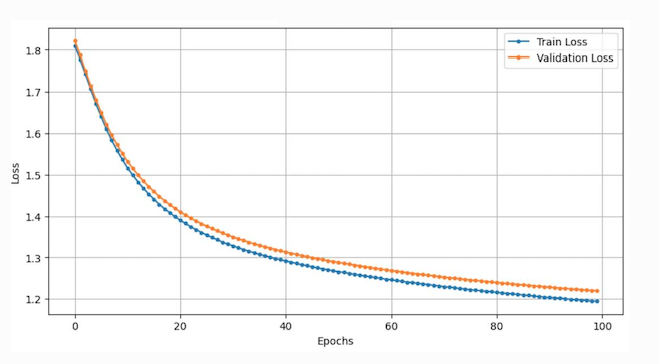

In [ ]:
# margin=2.0, out=1024
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=2.0, out=512
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=2.0, out=256
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=1.0, out=256
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=3.0, out=256
plot_umap_results(umap_f_emb, ds)

### Кластеризация разностей по **`linguistics_term`**

In [ ]:
# margin=2.0, out=1024
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=1.0, out=1024
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=3.0, out=1024
plot_umap_results(umap_f_emb, ds)

### Кластеризация разностей по **`field`**

In [ ]:
# margin=2.0, out=1024
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=2.0, out=256
plot_umap_results(umap_f_emb, ds)

In [ ]:
# margin=5.0, out=256
plot_umap_results(umap_f_emb, ds)